# Imports

In [42]:
import pandas as pd
from typing import Tuple

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pickle

import torch

import random 
import string

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# helper functions

In [3]:
def predict_intent(tokenizer, model, label_encoder, text:str) -> Tuple[str, float]:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=1)
    pred_label = torch.argmax(probs).item()
    score = probs[0, pred_label].item()
    intent = label_encoder.inverse_transform([pred_label])
    return intent[0], score

# Generating predictions

In [13]:
df_train = pd.read_csv("../../flask_back/rsc/datasets/train_aug.csv")
display(df_train.head(3))
display(df_train.shape)

df_test = pd.read_csv("../../flask_back/rsc/datasets/test_aug.csv")
display(df_test.head(3))
display(df_test.shape)

,text,intent_encoded,__index_level_0__,input_ids,attention_mask,labels,intent
0,This be Bella,8,25,[ 101 2023 2022 12101 102 0 0 ...,[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0],8,GreetingResponse
1,Who am I please,22,204,[ 101 2040 2572 1045 3531 102 0 0 0 ...,[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0],22,WhoAmI
2,I americium Bella,8,27,[ 101 1045 2572 22420 5007 12101 102 ...,[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0],8,GreetingResponse


(192, 7)

,text,intent_encoded,__index_level_0__,input_ids,attention_mask,labels,intent
0,Tell me what time it is?,20,110,[ 101 2425 2033 2054 2051 2009 2003 1029 102 ...,[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0],20,TimeQuery
1,Hello how are you?,2,34,[ 101 7592 2129 2024 2017 1029 102 0 0 ...,[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0],2,CourtesyGreeting
2,I am bored gossip with me,6,220,[ 101 1045 2572 11471 13761 2007 2033 1...,[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0],6,Gossip


(48, 7)

In [14]:
tokenizer = AutoTokenizer.from_pretrained('../../flask_back/rsc/tokenizer')
model = AutoModelForSequenceClassification.from_pretrained('../../flask_back/rsc/model')
with open('../../flask_back/rsc/label_encoder/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)

In [15]:
df_train[['predicted_class', 'score']] = df_train['text'].apply(lambda x: pd.Series(predict_intent(tokenizer=tokenizer, model=model, label_encoder=label_encoder, text=x)))
df_test[['predicted_class', 'score']] = df_test['text'].apply(lambda x: pd.Series(predict_intent(tokenizer=tokenizer, model=model, label_encoder=label_encoder, text=x)))

In [16]:
display(df_train.head(3))
display(df_train.shape)

display(df_test.head(3))
display(df_test.shape)

,text,intent_encoded,__index_level_0__,input_ids,attention_mask,labels,intent,predicted_class,score
0,This be Bella,8,25,[ 101 2023 2022 12101 102 0 0 ...,[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0],8,GreetingResponse,GreetingResponse,0.984068
1,Who am I please,22,204,[ 101 2040 2572 1045 3531 102 0 0 0 ...,[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0],22,WhoAmI,WhoAmI,0.971537
2,I americium Bella,8,27,[ 101 1045 2572 22420 5007 12101 102 ...,[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0],8,GreetingResponse,GreetingResponse,0.974697


(192, 9)

,text,intent_encoded,__index_level_0__,input_ids,attention_mask,labels,intent,predicted_class,score
0,Tell me what time it is?,20,110,[ 101 2425 2033 2054 2051 2009 2003 1029 102 ...,[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0],20,TimeQuery,TimeQuery,0.979745
1,Hello how are you?,2,34,[ 101 7592 2129 2024 2017 1029 102 0 0 ...,[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0],2,CourtesyGreeting,CourtesyGreeting,0.970004
2,I am bored gossip with me,6,220,[ 101 1045 2572 11471 13761 2007 2033 1...,[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0],6,Gossip,Gossip,0.961182


(48, 9)

# Evaluating the model


## classes distribuition

<Figure size 2000x1000 with 0 Axes>

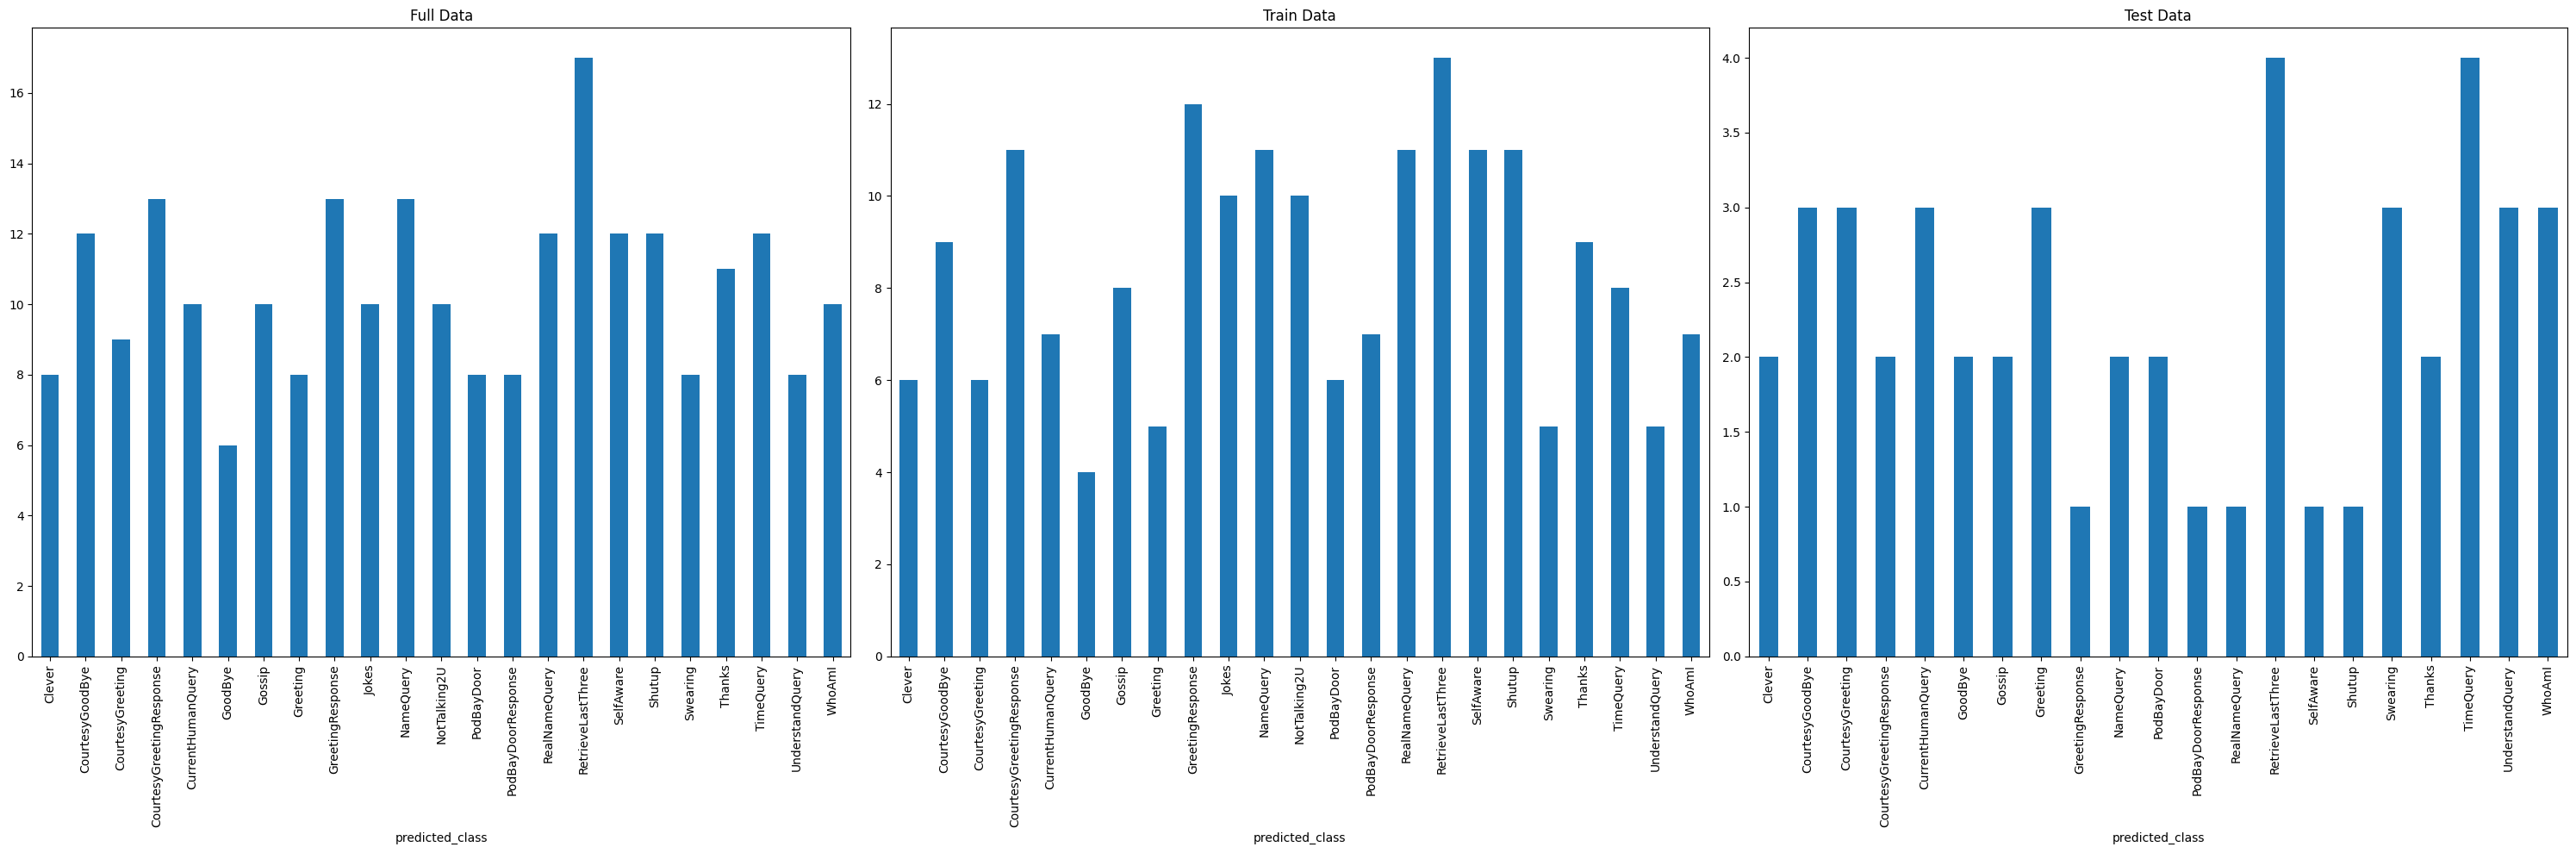

In [37]:
# for full, train, test 
df_full = pd.concat([df_train, df_test])

plt.figure(figsize=(20, 10))

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

df_full['predicted_class'].value_counts().sort_index().plot(kind='bar', ax=axes[0], title='Full Data')
df_train['predicted_class'].value_counts().sort_index().plot(kind='bar', ax=axes[1], title='Train Data')
df_test['predicted_class'].value_counts().sort_index().plot(kind='bar', ax=axes[2], title='Test Data')

for ax in axes:
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()

note that due to the small size of the dataset, the classes are not balanced. For example, "GreetingResponse" in train and full is the second most common class, but in the test set it does not show the same representation.

this means that the model will be evaluated on a slightly different distribution, which is great for our case because the model will be evaluated on a more realistic scenario.

## AUC-ROC and Acc(top1)+Recall+Precision

## AUC-ROC
The AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a performance measurement for classification problems at various threshold settings. It is a graphical representation that illustrates the diagnostic ability of a binary classifier system. However, for multiclass problems, the concept is extended to handle multiple classes. In a multiclass setting, the AUC-ROC can be computed using some approaches, but here we used one-vs-one: **One-vs-One (OvO):** Compare each pair of classes separately, compute the AUC for each pair, and take the average AUC as the overall performance metric.

**Interpretation:** The AUC value ranges from 0 to 1. A model with an AUC of 0.5 has no discrimination capability, while a model with an AUC of 1.0 has perfect discrimination. The ROC Curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The closer the curve follows the left-hand border and then the top border of the ROC space, the better the model. In summary, the AUC-ROC for multiclass problems provides a comprehensive measure of a model's performance across all classes, helping to understand how well the model distinguishes between different classes.


c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


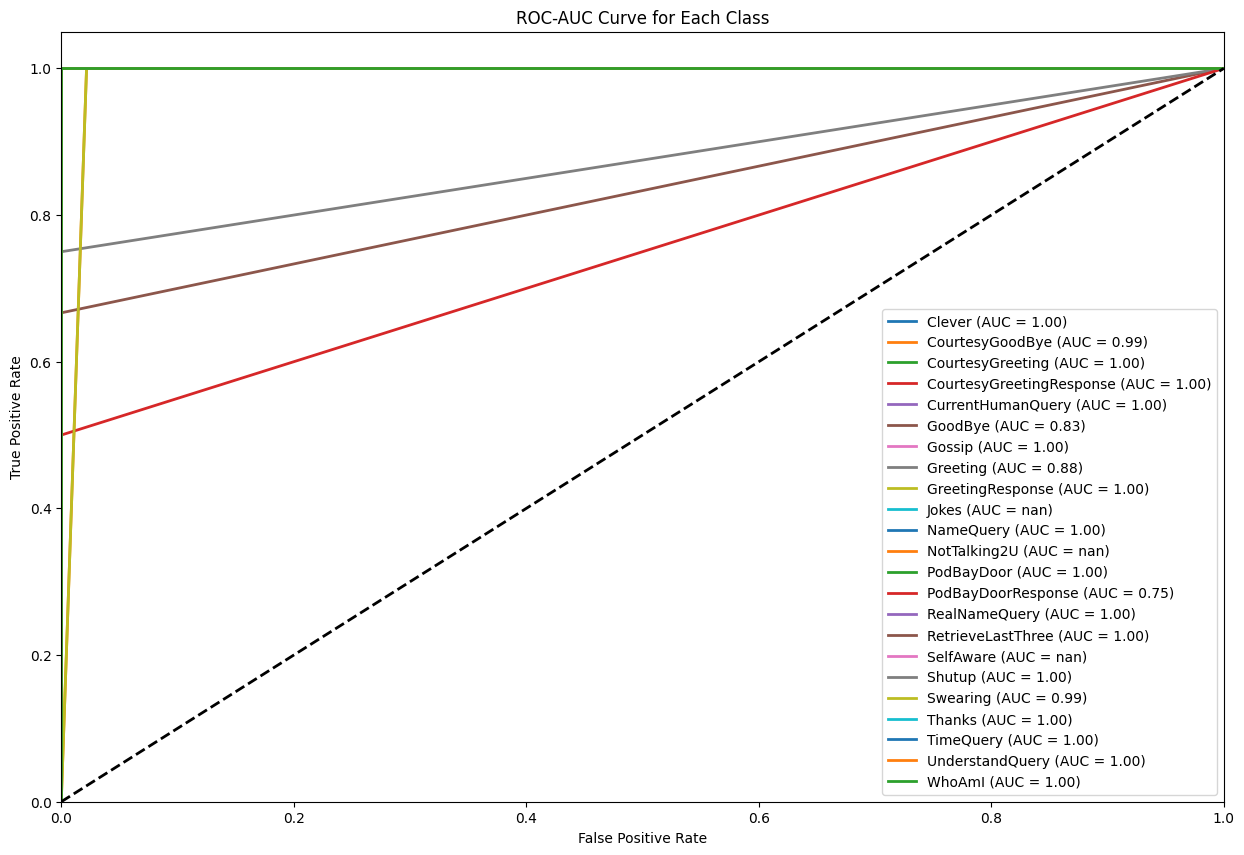

In [43]:
y_test = label_binarize(df_test['intent'], classes=categories)
y_score = label_binarize(df_test['predicted_class'], classes=categories)

plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{category} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Class')
plt.legend()
plt.show()


as we can see, the AUC on the test dataset is perfect (1.0) for most classes. Generally, this is a good result, but it could also indicate overfitting, so we need to be cautious. A larger dataset would allow for better evaluation, but for now, it is a positive sign.

## Accuracy Top-1

**Accuracy Top-1:** This metric measures the percentage of times the model's top prediction (the one with the highest probability) matches the true label. It is a standard accuracy measure for classification tasks.

## Precision and Recall


**Precision:** This metric measures the percentage of true positive predictions among all positive predictions made by the model. It indicates how many of the predicted positive instances are actually correct. Precision is crucial when the cost of false positives is high.

**Recall:** Also known as sensitivity or true positive rate, this metric measures the percentage of true positive predictions among all actual positive instances. It indicates how many of the actual positive instances are correctly identified by the model. Recall is important when the cost of false negatives is high.


In [45]:
from sklearn.metrics import precision_score, recall_score

def top_k_accuracy(df, k=1):
    correct = 0
    for i, row in df.iterrows():
        true_label = row['intent']
        predicted_labels = row['predicted_class'].split()[:k]
        if true_label in predicted_labels:
            correct += 1
    return correct / len(df)

top1_accuracy = top_k_accuracy(df_test, k=1)

precision = precision_score(df_test['intent'], df_test['predicted_class'], average='weighted')
recall = recall_score(df_test['intent'], df_test['predicted_class'], average='weighted')

print(f"Top-1 Accuracy: {top1_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Top-1 Accuracy: 0.94
Precision: 0.97
Recall: 0.94


c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


as we saw in the AUC-ROC, the model has a good performance in the test dataset, with high precision and recall for most classes. This is a positive sign, but we need to be cautious about overfitting, as mentioned before.
 

## confusion matrix

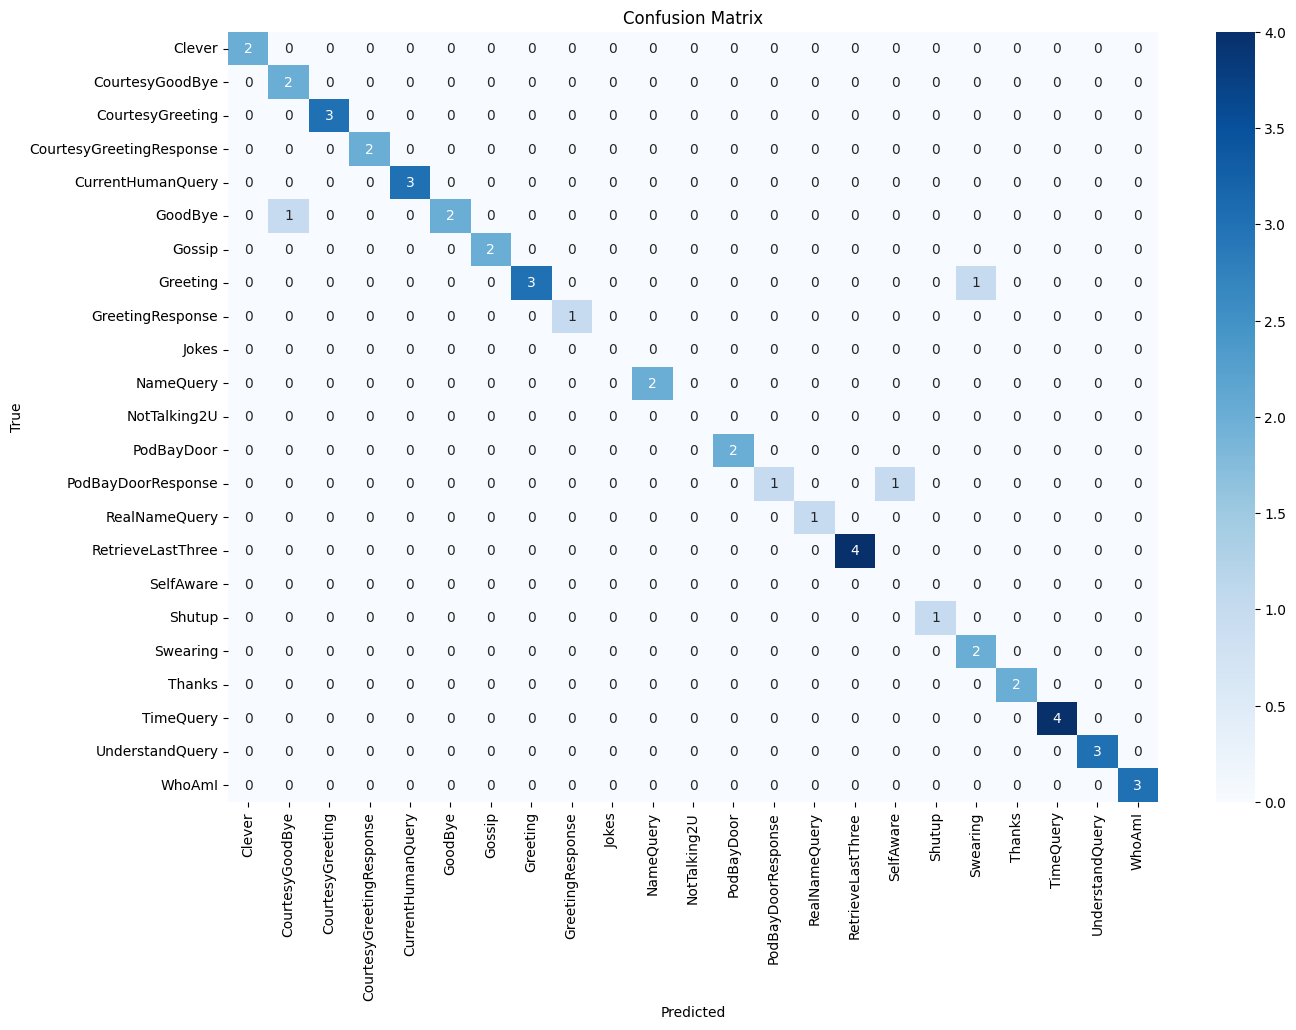

In [48]:
cm = confusion_matrix(df_test['intent'], df_test['predicted_class'], labels=categories)

plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We can dive deeper into the predictions using this confusion matrix. The 3 errors in the entire dataset were:

- **1**: "GoodBye" was predicted as "CourtesyGoodBye" – completely understandable, since these classes are very similar.
- **2**: "PodBayDoor" was predicted as "SelfAware" – this is a bit more unusual, but given the small volume of data, it's possible the model hasn't seen enough examples of these classes to distinguish them properly. Overall, this is still good because the other "PodBayDoor" examples were predicted correctly.
- **3**: "Greeting" was predicted as "Swearing" – similar to the second case. Despite the similarity between the classes, the model correctly predicted the other 3 examples.
